In [57]:

import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3.ap-geo.objectstorage.service.networklayer.com',
    'api_key': 'ExBB1T4rwYC5m04C2tlv1yy5BsKtvSU8pW5QNXcvQ3Cb',
    'service_id': 'iam-ServiceId-df93d563-b072-44a8-859f-cd3321417f12',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_29102620177244a6898d193c3a67464b_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-vq70a3dzz1nfot'))
df.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
# import libraries
#from pyspark.sql import SparkSession
from pyspark.sql.functions import add_months, avg, count, countDistinct, col, datediff,\
desc, expr, from_unixtime, floor, isnan, lag, lit, month, months_between,\
min, max, split, sum, udf, unix_timestamp, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from datetime import datetime

## Load and Clean Data

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Investigate timestamps

In [5]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              543705|
|   mean|1.540964541209800...|
| stddev|1.4820571449105084E9|
|    min|       1538352011000|
|    max|       1543622466000|
+-------+--------------------+



In [6]:
ts = int(1538352011000)
ts /= 1000
print("Start Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

ts = int(1543622466000)
ts /= 1000
print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Start Time: 2018-10-01 00:00:11
End Time: 2018-12-01 00:01:06


### Investigate pages

In [7]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



## Investigate missing and null values

In [8]:
# check NaN values per column
# taken from: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# check null values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [10]:
# filter out all entries with missing names.
# they are not recording information that we will need for the model
df = df.filter(df.firstName.isNotNull())

In [11]:
# check null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [12]:
# original timestamp in milliseconds, so divide by 1000
adjust_timestamp = udf(lambda x : x//1000, IntegerType())
df = df.withColumn("ts_adj", adjust_timestamp('ts'))

# convert adjusted timestamp to datetime
df = df.withColumn("datetime", from_unixtime(col("ts_adj")))

# convert registration timestamp to datetime
df = df.withColumn("reg_adj", adjust_timestamp('registration'))

# convert adjusted registration timestamp to datetime
df = df.withColumn("reg_datetime", from_unixtime(col("reg_adj")))

# drop all the timestamp columns. Will not need them
columns_to_drop = ['registration', 'ts', 'ts_adj', 'reg_adj']
df = df.drop(*columns_to_drop)

# add start date of analysis
df = df.withColumn('analysis_start_date', lit('2018-10-01 00:00:00'))

# number the months starting from the very first month of the analysis
df = df.withColumn("month_num", floor(months_between(df.datetime, df.analysis_start_date)))

In [13]:
# engineer free or paid binary variable
# free: 0, paid: 1
df = df.replace(["free", "paid"], ["0", "1"], "level")

# engineer male and female binary binary variable
# male: 0, female: 1
df = df.replace(["M", "F"], ["0", "1"], "gender")

## Define churn

In [14]:
# can possibly switch to a 2-class classification system
def define_churn(x):
    """
    Defining churn as cancellation of service or downgrading from premium to free tier.
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0
    
churn_event = udf(lambda x : define_churn(x), IntegerType())
    
df = df.withColumn("churn", churn_event("page"))

df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+------------------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|sessionId|              song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|churn|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+------------------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|    Martin Orford|Logged In|   Joseph|     0|           20| Morales|597.55057|    0|  Corpus Christi, TX|   PUT|NextSong|      292|     Grand Designs|   200|"Mozilla/5.0 (Mac...|   293|2018-10-01 00:00:11|2018-

In [15]:
df.select('month_num','churn').groupBy('month_num','churn').count().orderBy('month_num', 'churn').show()

+---------+-----+------+
|month_num|churn| count|
+---------+-----+------+
|        0|    0|268018|
|        0|    1|   108|
|        1|    0|259767|
|        1|    1|   108|
|        2|    0|     4|
+---------+-----+------+



In [16]:
# aggregate number of page visits for each user on a monthly basis

df_register = df.select('userId', 'month_num', 'page') \
.where(df.page=="Register") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numRegister')

df_cancel = df.select('userId', 'month_num', 'page') \
.where(df.page=="Cancel") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numCancelVisits')

df_upgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Upgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numUpgradeVisits')

df_downgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Downgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numDowngradeVisits')

df_home = df.select('userId', 'month_num', 'page') \
.where(df.page=="Home") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numHomeVisits')

df_about = df.select('userId', 'month_num', 'page') \
.where(df.page=="About") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAboutVisits')

df_settings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSettingsVisits')

df_saveSettings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Save Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSaveSettings')

df_login = df.select('userId', 'month_num', 'page') \
.where(df.page=="Login") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogins')

df_logout = df.select('userId', 'month_num', 'page') \
.where(df.page=="Logout") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogouts')

df_addPlaylist = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add to Playlist") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAddPlaylists')

df_addFriend = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add Friend") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numFriends')

df_thumbsUp = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Up") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsUp')

df_thumbsDown = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Down") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsDown')

df_advert = df.select('userId', 'month_num', 'page') \
.where(df.page=="Roll Advert") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAdverts')

df_songsPlayed = df.select('userId', 'month_num', 'page') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSongsPlayed')

df_totalListen = df.select('userId', 'month_num', 'length') \
.groupBy('userId', 'month_num') \
.agg({'length':'sum'}) \
.withColumnRenamed('sum(length)', 'totalListenTime')

# number of songs per session
df_songsPerSession = df.select('userId', 'month_num', 'page', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'SongsPerSession')
# avg number of songs per session
df_avgSongsPerSession = df_songsPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_songsPerSession.SongsPerSession).alias('avgSongsPerSession'))

# number of singers
df_singersPlayed = df.select('userId', 'month_num', 'page', 'artist') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg(countDistinct(df.artist).alias('numSingersPlayed'))

# number of singers per session
df_singersPerSession = df.select('userId', 'month_num', 'page', 'artist', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg(countDistinct(df.artist).alias('SingersPerSession'))
# avg number of singers per session
df_avgSingersPerSession = df_singersPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_singersPerSession.SingersPerSession).alias('avgSingersPerSession'))

# groupby user, month_num, sessionId.
df_userSession = df.groupBy("userId", "month_num", "sessionId") \
.agg(((max(unix_timestamp(df.datetime))-min(unix_timestamp(df.datetime)))/60.0).alias('sessionTimeMins'))
# Find avg session time
df_avgUserSession = df_userSession.groupBy('userId', 'month_num').agg(avg(df_userSession.sessionTimeMins).alias('avgSessionMins'))

# number of sessions
df_numSession = df.select('userId', 'month_num', 'sessionId').dropDuplicates() \
.groupby('userId', 'month_num').agg({'sessionId':'count'}) \
.withColumnRenamed('count(sessionId)', 'numSessions')

# if user had premium at any point of the month, assumer he/she has premium for
# the whole month for simplicity
df_level = df.select('userId', 'month_num', 'level') \
.groupBy('userId', 'month_num') \
.agg({'level':'max'}) \
.withColumnRenamed('max(level)', 'level')

# assuming nobody changes gender midway
df_gender = df.select('userId', 'month_num', 'gender') \
.groupBy('userId', 'month_num') \
.agg({'gender':'max'}) \
.withColumnRenamed('max(gender)', 'gender')

# start of each month
# from https://stackoverflow.com/questions/45612208/add-months-to-date-column-in-spark-dataframe
df = df.withColumn("start_of_month", expr("add_months(analysis_start_date, month_num)"))
# days since registration from start of each month
# from https://stackoverflow.com/questions/44020818/how-to-calculate-date-difference-in-pyspark
df = df.withColumn("daysSinceReg", datediff(df.start_of_month, df.reg_datetime))
#
df_daysReg = df.select('userId', 'month_num', 'daysSinceReg') \
.groupBy('userId', 'month_num') \
.agg(min(df.daysSinceReg).alias('daysSinceReg'))

df_churn = df.select('userId', 'month_num', 'churn') \
.groupBy('userId', 'month_num') \
.agg({'churn':'max'}) \
.withColumnRenamed('max(churn)', 'churn')

In [17]:
all_data = df_register.join(df_cancel, ['userId', 'month_num'], 'outer') \
.join(df_upgrade, ['userId', 'month_num'], 'outer') \
.join(df_downgrade, ['userId', 'month_num'], 'outer') \
.join(df_home, ['userId', 'month_num'], 'outer') \
.join(df_about, ['userId', 'month_num'], 'outer') \
.join(df_settings, ['userId', 'month_num'], 'outer') \
.join(df_saveSettings, ['userId', 'month_num'], 'outer') \
.join(df_login, ['userId', 'month_num'], 'outer') \
.join(df_logout, ['userId', 'month_num'], 'outer') \
.join(df_addPlaylist, ['userId', 'month_num'], 'outer') \
.join(df_addFriend, ['userId', 'month_num'], 'outer') \
.join(df_thumbsUp, ['userId', 'month_num'], 'outer') \
.join(df_thumbsDown, ['userId', 'month_num'], 'outer') \
.join(df_advert, ['userId', 'month_num'], 'outer') \
.join(df_songsPlayed, ['userId', 'month_num'], 'outer') \
.join(df_totalListen, ['userId', 'month_num'], 'outer') \
.join(df_avgSongsPerSession, ['userId', 'month_num'], 'outer') \
.join(df_singersPlayed, ['userId', 'month_num']) \
.join(df_avgSingersPerSession, ['userId', 'month_num'], 'outer') \
.join(df_avgUserSession, ['userId', 'month_num'], 'outer') \
.join(df_numSession, ['userId', 'month_num'], 'outer') \
.join(df_level, ['userId', 'month_num'], 'outer') \
.join(df_gender, ['userId', 'month_num'], 'outer') \
.join(df_daysReg, ['userId', 'month_num'], 'outer') \
.join(df_churn, ['userId', 'month_num'], 'outer')

In [18]:
windowlag = (Window.partitionBy('userId').orderBy('month_num'))

# generate 1 month lag features
all_data = all_data.withColumn('numRegister_lastMonth', lag(all_data['numRegister']).over(windowlag))
all_data = all_data.withColumn('numCancelVisits_lastMonth', lag(all_data['numCancelVisits']).over(windowlag))
all_data = all_data.withColumn('numUpgradeVisits_lastMonth', lag(all_data['numUpgradeVisits']).over(windowlag))
all_data = all_data.withColumn('numDowngradeVisits_lastMonth', lag(all_data['numDowngradeVisits']).over(windowlag))
all_data = all_data.withColumn('numHomeVisits_lastMonth', lag(all_data['numHomeVisits']).over(windowlag))
all_data = all_data.withColumn('numAboutVisits_lastMonth', lag(all_data['numAboutVisits']).over(windowlag))
all_data = all_data.withColumn('numSettingsVisits_lastMonth', lag(all_data['numSettingsVisits']).over(windowlag))
all_data = all_data.withColumn('numSaveSettings_lastMonth', lag(all_data['numSaveSettings']).over(windowlag))
all_data = all_data.withColumn('numLogins_lastMonth', lag(all_data['numLogins']).over(windowlag))
all_data = all_data.withColumn('numLogouts_lastMonth', lag(all_data['numLogouts']).over(windowlag))
all_data = all_data.withColumn('numAddPlaylists_lastMonth', lag(all_data['numAddPlaylists']).over(windowlag))
all_data = all_data.withColumn('numFriends_lastMonth', lag(all_data['numFriends']).over(windowlag))
all_data = all_data.withColumn('numThumbsUp_lastMonth', lag(all_data['numThumbsUp']).over(windowlag))
all_data = all_data.withColumn('numThumbsDown_lastMonth', lag(all_data['numThumbsDown']).over(windowlag))
all_data = all_data.withColumn('numAdverts_lastMonth', lag(all_data['numAdverts']).over(windowlag))
all_data = all_data.withColumn('numSongsPlayed_lastMonth', lag(all_data['numSongsPlayed']).over(windowlag))
all_data = all_data.withColumn('totalListenTime_lastMonth', lag(all_data['totalListenTime']).over(windowlag))
all_data = all_data.withColumn('avgSongsPerSession_lastMonth', lag(all_data['avgSongsPerSession']).over(windowlag))
all_data = all_data.withColumn('numSingersPlayed_lastMonth', lag(all_data['numSingersPlayed']).over(windowlag))
all_data = all_data.withColumn('avgSingersPerSession_lastMonth', lag(all_data['avgSingersPerSession']).over(windowlag))
all_data = all_data.withColumn('avgSessionMins_lastMonth', lag(all_data['avgSessionMins']).over(windowlag))
all_data = all_data.withColumn('numSessions_lastMonth', lag(all_data['numSessions']).over(windowlag))
all_data = all_data.withColumn('level_lastMonth', lag(all_data['level']).over(windowlag))

In [19]:
all_data.show(5)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+
|userId|month_num|numRegister|numCancelVisits|numUpg

In [21]:
windowMov = (Window.partitionBy('userId').orderBy('month_num')
             .rangeBetween(Window.unboundedPreceding, 0))

# generate moving averages from previous months, not including current mmonth.
# For small dataset, it will be the same as the 1 month lag values
# since there are only 2 months. For the full dataset, there may be more than 2 months, 
# so moving averages will be different from 1 month lag
all_data = all_data.withColumn('numRegister_cum_old', sum('numRegister').over(windowMov))
all_data = all_data.withColumn('numRegister_cum',\
                               (all_data['numRegister_cum_old'] - all_data['numRegister']))
all_data = all_data.withColumn('numRegister_movAvg',\
                               (all_data['numRegister_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numCancelVisits_cum_old', sum('numCancelVisits').over(windowMov))
all_data = all_data.withColumn('numCancelVisits_cum',\
                               (all_data['numCancelVisits_cum_old'] - all_data['numCancelVisits']))
all_data = all_data.withColumn('numCancelVisits_movAvg',\
                               (all_data['numCancelVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numUpgradeVisits_cum_old', sum('numUpgradeVisits').over(windowMov))
all_data = all_data.withColumn('numUpgradeVisits_cum',\
                               (all_data['numUpgradeVisits_cum_old'] - all_data['numUpgradeVisits']))
all_data = all_data.withColumn('numUpgradeVisits_movAvg',\
                               (all_data['numUpgradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numDowngradeVisits_cum_old', sum('numDowngradeVisits').over(windowMov))
all_data = all_data.withColumn('numDowngradeVisits_cum',\
                               (all_data['numDowngradeVisits_cum_old'] - all_data['numDowngradeVisits']))
all_data = all_data.withColumn('numDowngradeVisits_movAvg',\
                               (all_data['numDowngradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numHomeVisits_cum_old', sum('numHomeVisits').over(windowMov))
all_data = all_data.withColumn('numHomeVisits_cum',\
                               (all_data['numHomeVisits_cum_old'] - all_data['numHomeVisits']))
all_data = all_data.withColumn('numHomeVisits_movAvg',\
                               (all_data['numHomeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAboutVisits_cum_old', sum('numAboutVisits').over(windowMov))
all_data = all_data.withColumn('numAboutVisits_cum',\
                               (all_data['numAboutVisits_cum_old'] - all_data['numAboutVisits']))
all_data = all_data.withColumn('numAboutVisits_movAvg',\
                               (all_data['numAboutVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSettingsVisits_cum_old', sum('numSettingsVisits').over(windowMov))
all_data = all_data.withColumn('numSettingsVisits_cum',\
                               (all_data['numSettingsVisits_cum_old'] - all_data['numSettingsVisits']))
all_data = all_data.withColumn('numSettingsVisits_movAvg',\
                               (all_data['numSettingsVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSaveSettings_cum_old', sum('numSaveSettings').over(windowMov))
all_data = all_data.withColumn('numSaveSettings_cum',\
                               (all_data['numSaveSettings_cum_old'] - all_data['numSaveSettings']))
all_data = all_data.withColumn('numSaveSettings_movAvg',\
                               (all_data['numSaveSettings_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogins_cum_old', sum('numLogins').over(windowMov))
all_data = all_data.withColumn('numLogins_cum',\
                               (all_data['numLogins_cum_old'] - all_data['numLogins']))
all_data = all_data.withColumn('numLogins_movAvg',\
                               (all_data['numLogins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogouts_cum_old', sum('numLogouts').over(windowMov))
all_data = all_data.withColumn('numLogouts_cum',\
                               (all_data['numLogouts_cum_old'] - all_data['numLogouts']))
all_data = all_data.withColumn('numLogouts_movAvg',\
                               (all_data['numLogouts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAddPlaylists_cum_old', sum('numAddPlaylists').over(windowMov))
all_data = all_data.withColumn('numAddPlaylists_cum',\
                               (all_data['numAddPlaylists_cum_old'] - all_data['numAddPlaylists']))
all_data = all_data.withColumn('numAddPlaylists_movAvg',\
                               (all_data['numAddPlaylists_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numFriends_cum_old', sum('numFriends').over(windowMov))
all_data = all_data.withColumn('numFriends_cum',\
                               (all_data['numFriends_cum_old'] - all_data['numFriends']))
all_data = all_data.withColumn('numFriends_movAvg',\
                               (all_data['numFriends_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsUp_cum_old', sum('numThumbsUp').over(windowMov))
all_data = all_data.withColumn('numThumbsUp_cum',\
                               (all_data['numThumbsUp_cum_old'] - all_data['numThumbsUp']))
all_data = all_data.withColumn('numThumbsUp_movAvg',\
                               (all_data['numThumbsUp_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsDown_cum_old', sum('numThumbsDown').over(windowMov))
all_data = all_data.withColumn('numThumbsDown_cum',\
                               (all_data['numThumbsDown_cum_old'] - all_data['numThumbsDown']))
all_data = all_data.withColumn('numThumbsDown_movAvg',\
                               (all_data['numThumbsDown_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAdverts_cum_old', sum('numAdverts').over(windowMov))
all_data = all_data.withColumn('numAdverts_cum',\
                               (all_data['numAdverts_cum_old'] - all_data['numAdverts']))
all_data = all_data.withColumn('numAdverts_movAvg',\
                               (all_data['numAdverts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSongsPlayed_cum_old', sum('numSongsPlayed').over(windowMov))
all_data = all_data.withColumn('numSongsPlayed_cum',\
                               (all_data['numSongsPlayed_cum_old'] - all_data['numSongsPlayed']))
all_data = all_data.withColumn('numSongsPlayed_movAvg',\
                               (all_data['numSongsPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('totalListenTime_cum_old', sum('totalListenTime').over(windowMov))
all_data = all_data.withColumn('totalListenTime_cum',\
                               (all_data['totalListenTime_cum_old'] - all_data['totalListenTime']))
all_data = all_data.withColumn('totalListenTime_movAvg',\
                               (all_data['totalListenTime_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSongsPerSession_cum_old', sum('avgSongsPerSession').over(windowMov))
all_data = all_data.withColumn('avgSongsPerSession_cum',\
                               (all_data['avgSongsPerSession_cum_old'] - all_data['avgSongsPerSession']))
all_data = all_data.withColumn('avgSongsPerSession_movAvg',\
                               (all_data['avgSongsPerSession_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSingersPlayed_cum_old', sum('numSingersPlayed').over(windowMov))
all_data = all_data.withColumn('numSingersPlayed_cum',\
                               (all_data['numSingersPlayed_cum_old'] - all_data['numSingersPlayed']))
all_data = all_data.withColumn('numSingersPlayed_movAvg',\
                               (all_data['numSingersPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSingersPerSession_cum_old', sum('avgSingersPerSession').over(windowMov))
all_data = all_data.withColumn('avgSingersPerSession_cum',\
                               (all_data['avgSingersPerSession_cum_old'] - all_data['avgSingersPerSession']))
all_data = all_data.withColumn('avgSingersPerSession_movAvg',\
                               (all_data['avgSingersPerSession_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSessionMins_cum_old', sum('avgSessionMins').over(windowMov))
all_data = all_data.withColumn('avgSessionMins_cum',\
                               (all_data['avgSessionMins_cum_old'] - all_data['avgSessionMins']))
all_data = all_data.withColumn('avgSessionMins_movAvg',\
                               (all_data['avgSessionMins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSessions_cum_old', sum('numSessions').over(windowMov))
all_data = all_data.withColumn('numSessions_cum',\
                               (all_data['numSessions_cum_old'] - all_data['numSessions']))
all_data = all_data.withColumn('numSessions_movAvg',\
                               (all_data['numSessions_cum'] / all_data['month_num']))

In [22]:
all_data.show(5)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+-----------------

In [23]:
# fill na/null values with 0
all_data = all_data.na.fill(0.0)

all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+---------------+------------------+----------------+--------------------+--------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+------------------+-----

In [24]:
# Engineer diffs between last months stats and moving averages.
# for the small dataset, the differences will be 0 since there were only 2 months
all_data = all_data.withColumn('diff_numRegister', (all_data['numRegister_lastMonth'] - all_data['numRegister_movAvg']))
all_data = all_data.withColumn('diff_numCancelVisits', (all_data['numCancelVisits_lastMonth'] - all_data['numCancelVisits_movAvg']))
all_data = all_data.withColumn('diff_numUpgradeVisits', (all_data['numUpgradeVisits_lastMonth'] - all_data['numUpgradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numDowngradeVisits', (all_data['numDowngradeVisits_lastMonth'] - all_data['numDowngradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numHomeVisits', (all_data['numHomeVisits_lastMonth'] - all_data['numHomeVisits_movAvg']))
all_data = all_data.withColumn('diff_numAboutVisits', (all_data['numAboutVisits_lastMonth'] - all_data['numAboutVisits_movAvg']))
all_data = all_data.withColumn('diff_numSettingsVisits', (all_data['numSettingsVisits_lastMonth'] - all_data['numSettingsVisits_movAvg']))
all_data = all_data.withColumn('diff_numSaveSettings', (all_data['numSaveSettings_lastMonth'] - all_data['numSaveSettings_movAvg']))
all_data = all_data.withColumn('diff_numLogins', (all_data['numLogins_lastMonth'] - all_data['numLogins_movAvg']))
all_data = all_data.withColumn('diff_numLogouts', (all_data['numLogouts_lastMonth'] - all_data['numLogouts_movAvg']))
all_data = all_data.withColumn('diff_numAddPlaylists', (all_data['numAddPlaylists_lastMonth'] - all_data['numAddPlaylists_movAvg']))
all_data = all_data.withColumn('diff_numFriends', (all_data['numFriends_lastMonth'] - all_data['numFriends_movAvg']))
all_data = all_data.withColumn('diff_numThumbsUp', (all_data['numThumbsUp_lastMonth'] - all_data['numThumbsUp_movAvg']))
all_data = all_data.withColumn('diff_numThumbsDown', (all_data['numThumbsDown_lastMonth'] - all_data['numThumbsDown_movAvg']))
all_data = all_data.withColumn('diff_numAdverts', (all_data['numAdverts_lastMonth'] - all_data['numAdverts_movAvg']))
all_data = all_data.withColumn('diff_numSongsPlayed', (all_data['numSongsPlayed_lastMonth'] - all_data['numSongsPlayed_movAvg']))
all_data = all_data.withColumn('diff_totalListenTime', (all_data['totalListenTime_lastMonth'] - all_data['totalListenTime_movAvg']))
all_data = all_data.withColumn('diff_avgSongsPerSession', (all_data['avgSongsPerSession_lastMonth'] - all_data['avgSongsPerSession_movAvg']))
all_data = all_data.withColumn('diff_numSingersPlayed', (all_data['numSingersPlayed_lastMonth'] - all_data['numSingersPlayed_movAvg']))
all_data = all_data.withColumn('diff_avgSingersPerSession', (all_data['avgSingersPerSession_lastMonth'] - all_data['avgSingersPerSession_movAvg']))
all_data = all_data.withColumn('diff_avgSessionMins', (all_data['avgSessionMins_lastMonth'] - all_data['avgSessionMins_movAvg']))
all_data = all_data.withColumn('diff_numSessions', (all_data['numSessions_lastMonth'] - all_data['numSessions_movAvg']))

## Exploratory Data Analysis

In [25]:
# visualize 1 month lag values
all_data_pd = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth', 'gender', 'daysSinceReg', 'churn'
        ).toPandas()

all_data_pd.head()

,numRegister_lastMonth,numCancelVisits_lastMonth,numUpgradeVisits_lastMonth,numDowngradeVisits_lastMonth,numHomeVisits_lastMonth,numAboutVisits_lastMonth,numSettingsVisits_lastMonth,numSaveSettings_lastMonth,numLogins_lastMonth,numLogouts_lastMonth,...,totalListenTime_lastMonth,avgSongsPerSession_lastMonth,numSingersPlayed_lastMonth,avgSingersPerSession_lastMonth,avgSessionMins_lastMonth,numSessions_lastMonth,level_lastMonth,gender,daysSinceReg,churn
0,0,0,0,0,1,0,3,0,0,0,...,14632.72472,29.000000,57,28.500000,118.066667,2,0,0,92,0
1,0,0,0,9,43,1,12,3,0,11,...,293905.64972,130.222222,858,117.333333,487.268333,10,1,1,102,1
2,0,0,3,0,22,1,3,1,0,7,...,58918.29257,26.333333,224,26.000000,107.729630,9,0,0,51,0
3,0,0,2,0,1,0,1,0,0,0,...,9965.43446,10.250000,41,10.250000,37.387500,4,0,0,50,0
4,0,0,0,3,18,2,0,0,0,6,...,87588.04928,115.000000,309,109.333333,483.300000,3,1,1,32,0


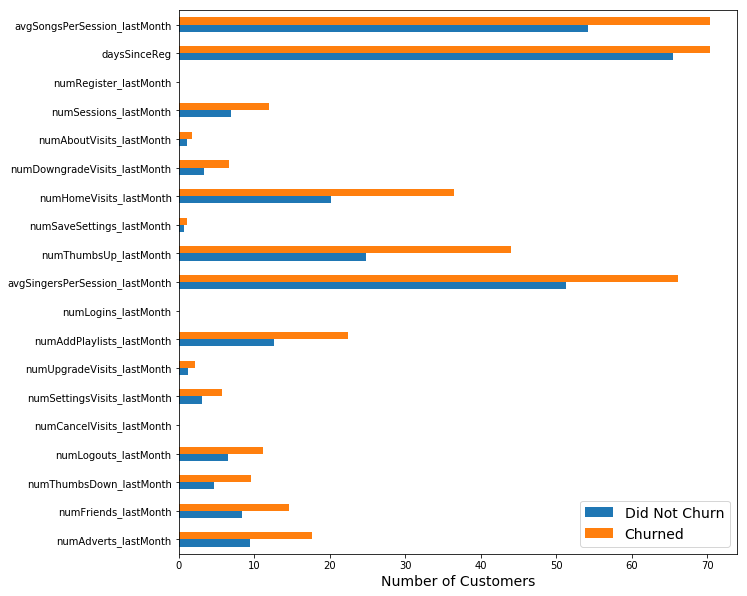

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
all_data_pd.groupby('churn').agg({'numRegister_lastMonth':'mean',\
                                  'numCancelVisits_lastMonth':'mean',\
                                  'numUpgradeVisits_lastMonth':'mean',\
                                  'numDowngradeVisits_lastMonth':'mean',\
                                  'numHomeVisits_lastMonth':'mean',\
                                  'numAboutVisits_lastMonth':'mean',\
                                  'numSettingsVisits_lastMonth':'mean',\
                                  'numSaveSettings_lastMonth':'mean',\
                                  'numLogins_lastMonth':'mean',\
                                  'numLogouts_lastMonth':'mean',\
                                  'numAddPlaylists_lastMonth':'mean',\
                                  'numFriends_lastMonth':'mean',\
                                  'numThumbsUp_lastMonth':'mean',\
                                  'numThumbsDown_lastMonth':'mean',\
                                  'numAdverts_lastMonth':'mean',\
                                  'daysSinceReg':'mean',\
                                  'avgSongsPerSession_lastMonth':'mean',\
                                  'avgSingersPerSession_lastMonth':'mean',\
                                  'numSessions_lastMonth':'mean'
                                 }).T.plot.barh(ax=ax);
ax.set_xlabel("Number of Customers", fontsize=14)
ax.legend(["Did Not Churn", "Churned"], fontsize=14);
fig.savefig("churn_dist_1_medium.jpg", bbox_inches='tight')

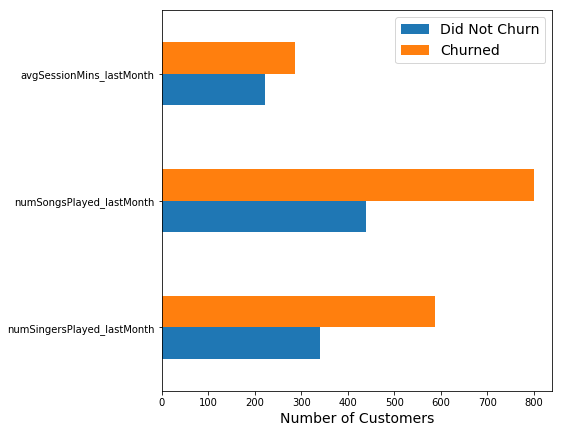

In [39]:
fig, ax = plt.subplots(figsize=(7,7))
all_data_pd.groupby('churn').agg({'numSongsPlayed_lastMonth':'mean',\
                                  'numSingersPlayed_lastMonth':'mean',\
                                  'avgSessionMins_lastMonth':'mean'
                                 }).T.plot.barh(ax=ax);
ax.set_xlabel("Number of Customers", fontsize=14)
ax.legend(["Did Not Churn", "Churned"], fontsize=14);
fig.savefig("churn_dist_2_medium.jpg", bbox_inches='tight')

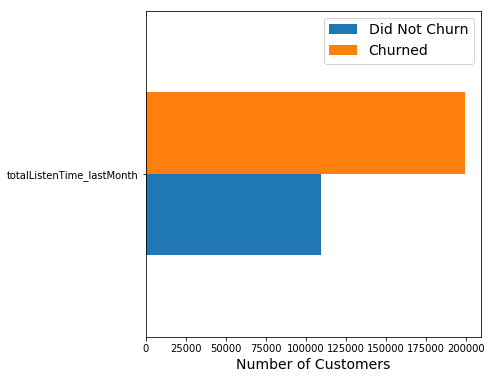

In [41]:
fig, ax = plt.subplots(figsize=(6,6))
all_data_pd.groupby('churn').agg({'totalListenTime_lastMonth':'mean'}).T.plot.barh(ax=ax);
ax.set_xlabel("Number of Customers", fontsize=14)
ax.legend(["Did Not Churn", "Churned"], fontsize=14);
fig.savefig("churn_dist_3_medium.jpg", bbox_inches='tight')

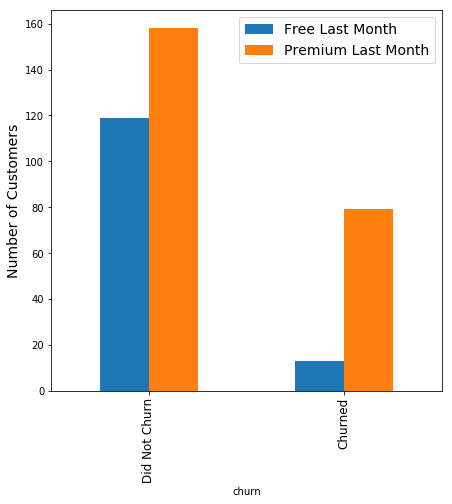

In [47]:
fig, ax = plt.subplots(figsize=(7,7))
all_data_pd.groupby(['churn', 'level_lastMonth']).agg({'level_lastMonth':'count'}).unstack().plot.bar(ax=ax);
ax.legend(["Free Last Month", "Premium Last Month"], fontsize=14);
ax.set_xticklabels(["Did Not Churn","Churned"], fontsize=12);
ax.set_ylabel("Number of Customers", fontsize=14);
fig.savefig("churn_level_medium.jpg", bbox_inches='tight')

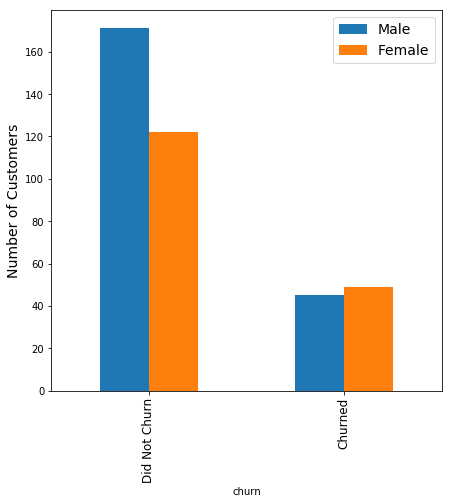

In [48]:
fig, ax = plt.subplots(figsize=(7,7))
all_data_pd.groupby(['churn', 'gender']).agg({'gender':'count'}).unstack().plot.bar(ax=ax);
ax.legend(["Male", "Female"], fontsize=14);
ax.set_xticklabels(["Did Not Churn","Churned"], fontsize=12);
ax.set_ylabel("Number of Customers", fontsize=14);
fig.savefig("churn_gender_medium.jpg", bbox_inches='tight')

In [33]:
all_data_pd.churn.value_counts()

0    293
1     94
Name: churn, dtype: int64

## Additional Data Adjustments

In [49]:
# convert userId, gender, level, level_lastMonth to numeric
convert_numeric = ['userId', 'level', 'gender', 'level_lastMonth']
for feat in convert_numeric:
    featName = feat + "_n"
    all_data = all_data.withColumn(featName, all_data[feat].cast("float"))
    all_data = all_data.drop(feat)
    
# fill na/null values with 0
all_data = all_data.na.fill(0.0)

In [50]:
all_data.persist()

DataFrame[month_num: bigint, numRegister: bigint, numCancelVisits: bigint, numUpgradeVisits: bigint, numDowngradeVisits: bigint, numHomeVisits: bigint, numAboutVisits: bigint, numSettingsVisits: bigint, numSaveSettings: bigint, numLogins: bigint, numLogouts: bigint, numAddPlaylists: bigint, numFriends: bigint, numThumbsUp: bigint, numThumbsDown: bigint, numAdverts: bigint, numSongsPlayed: bigint, totalListenTime: double, avgSongsPerSession: double, numSingersPlayed: bigint, avgSingersPerSession: double, avgSessionMins: double, numSessions: bigint, daysSinceReg: int, churn: int, numRegister_lastMonth: bigint, numCancelVisits_lastMonth: bigint, numUpgradeVisits_lastMonth: bigint, numDowngradeVisits_lastMonth: bigint, numHomeVisits_lastMonth: bigint, numAboutVisits_lastMonth: bigint, numSettingsVisits_lastMonth: bigint, numSaveSettings_lastMonth: bigint, numLogins_lastMonth: bigint, numLogouts_lastMonth: bigint, numAddPlaylists_lastMonth: bigint, numFriends_lastMonth: bigint, numThumbsUp_

## Modelling

In [51]:
all_data.columns

['month_num',
 'numRegister',
 'numCancelVisits',
 'numUpgradeVisits',
 'numDowngradeVisits',
 'numHomeVisits',
 'numAboutVisits',
 'numSettingsVisits',
 'numSaveSettings',
 'numLogins',
 'numLogouts',
 'numAddPlaylists',
 'numFriends',
 'numThumbsUp',
 'numThumbsDown',
 'numAdverts',
 'numSongsPlayed',
 'totalListenTime',
 'avgSongsPerSession',
 'numSingersPlayed',
 'avgSingersPerSession',
 'avgSessionMins',
 'numSessions',
 'daysSinceReg',
 'churn',
 'numRegister_lastMonth',
 'numCancelVisits_lastMonth',
 'numUpgradeVisits_lastMonth',
 'numDowngradeVisits_lastMonth',
 'numHomeVisits_lastMonth',
 'numAboutVisits_lastMonth',
 'numSettingsVisits_lastMonth',
 'numSaveSettings_lastMonth',
 'numLogins_lastMonth',
 'numLogouts_lastMonth',
 'numAddPlaylists_lastMonth',
 'numFriends_lastMonth',
 'numThumbsUp_lastMonth',
 'numThumbsDown_lastMonth',
 'numAdverts_lastMonth',
 'numSongsPlayed_lastMonth',
 'totalListenTime_lastMonth',
 'avgSongsPerSession_lastMonth',
 'numSingersPlayed_lastMonth',

In [52]:
# drop month 0 since we do not have old information to predict churn for this month
# keep only features to be trained and labels

model_data = all_data \
.filter(all_data.month_num>0) \
.select('userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth', \
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth_n', 'numRegister_movAvg', 'numCancelVisits_movAvg',\
        'numUpgradeVisits_movAvg', 'numDowngradeVisits_movAvg',\
        'numHomeVisits_movAvg', 'numAboutVisits_movAvg',\
        'numSettingsVisits_movAvg', 'numSaveSettings_movAvg',\
        'numLogins_movAvg', 'numLogouts_movAvg',\
        'numAddPlaylists_movAvg', 'numFriends_movAvg',\
        'numThumbsUp_movAvg', 'numThumbsDown_movAvg',\
        'numAdverts_movAvg', 'numSongsPlayed_movAvg',\
        'totalListenTime_movAvg', 'avgSongsPerSession_movAvg',\
        'numSingersPlayed_movAvg', 'avgSingersPerSession_movAvg',\
        'avgSessionMins_movAvg', 'numSessions_movAvg',\
        'diff_numRegister', 'diff_numCancelVisits',\
        'diff_numUpgradeVisits', 'diff_numDowngradeVisits',\
        'diff_numHomeVisits', 'diff_numAboutVisits',\
        'diff_numSettingsVisits', 'diff_numSaveSettings',\
        'diff_numLogins', 'diff_numLogouts',\
        'diff_numAddPlaylists', 'diff_numFriends',\
        'diff_numThumbsUp', 'diff_numThumbsDown',\
        'diff_numAdverts', 'diff_numSongsPlayed',\
        'diff_totalListenTime', 'diff_avgSongsPerSession',\
        'diff_numSingersPlayed', 'diff_avgSingersPerSession',
        'diff_avgSessionMins', 'diff_numSessions',\
        'gender_n', 'daysSinceReg', 'churn'
        ).withColumnRenamed('churn', 'label')

model_data.show(1)

+--------+---------+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+-----------------+------------------+----------------------+-----------------------+-------------------------+--------------------+---------------------+------------------------+----------------------+----------------+-----------------+----------------------+-----------------+------------------+--------------------+-----------------+---------------------+----------------------+-------------------------+-----------------------+---

In [53]:
# check null values one last time
model_data.select([count(when(col(c).isNull(), c)).alias(c) for c in model_data.columns]).show()

+--------+---------+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+-----------------+------------------+----------------------+-----------------------+-------------------------+--------------------+---------------------+------------------------+----------------------+----------------+-----------------+----------------------+-----------------+------------------+--------------------+-----------------+---------------------+----------------------+-------------------------+-----------------------+---

In [54]:
# for small dataset with 2 months, just use randomSplit
# for bigger datasets with multiple months, can split according to months
train,test = model_data.randomSplit([0.8, 0.2], seed=50)

In [55]:
# for small dataset, just train with last month's stats since there are only 2 months
# for large dataset, can train with last month's stats, moving averages and diffs

# small dataset
inputColumns = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
                'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
                'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
                'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
                'numLogins_lastMonth', 'numLogouts_lastMonth', \
                'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
                'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
                'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
                'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
                'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
                'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
                'level_lastMonth_n', 'gender_n', 'daysSinceReg']


assembler = VectorAssembler(inputCols=inputColumns, outputCol="FeaturesVec")
#data = assembler.transform(model_data)

scaler = StandardScaler(inputCol="FeaturesVec", outputCol="features", withMean=True, withStd=True)
#scalerModel = scaler.fit(data)
#data = scalerModel.transform(data)
#data = data.select(data.churn.alias("label"), data.ScaledFeatures.alias("features"))

# set max_iter to 30 for prototype, instead of the default 100, to save time

# Logistic Regression
lr=LogisticRegression(maxIter=30)
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# Support Vector Machine Classifier
svc = LinearSVC(maxIter=30)
pipeline_svc = Pipeline(stages=[assembler, scaler, svc])

# Gradient Boosted Trees
gbt = GBTClassifier(maxIter=20, seed=42)
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

### Logistic Regression

In [58]:
# logistic Regression
# Using default L2 regularization
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1, 0.2, 0.5]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_lr = cv_lr.fit(train)

In [59]:
cvModel_lr.avgMetrics

[0.7303574819165455,
 0.7158180273685165,
 0.7062561829345504,
 0.6950544533353922,
 0.695475292475658]

In [60]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_lr.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {cvModel_lr.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_lr.avgMetrics)
])

,f1,regParam
0,0.730357,0.00
1,0.715818,0.05
2,0.706256,0.10
3,0.695054,0.20
4,0.695475,0.50


In [61]:
lr_results = cvModel_lr.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Logistic Regression Model --- Accuracy is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"}))

Logistic Regression Model --- Accuracy is: 
0.6710526315789473


In [62]:
print("Logistic Regression Model --- F1-Score is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"}))

Logistic Regression Model --- F1-Score is: 
0.6320437342304457


### Linear SVC

In [ ]:
# Linear Support Vector Machine
# Using L2 regularization
paramGrid = ParamGridBuilder() \
    .addGrid(svc.regParam,[0.0, 0.05, 0.1, 0.2, 0.5]) \
    .build()

cv_svc = CrossValidator(estimator=pipeline_svc,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_svc = cv_svc.fit(train)

In [ ]:
cvModel_svc.avgMetrics

[0.6805317480921693,
 0.6799509242213667,
 0.6760695890047673,
 0.6495284560346812,
 0.6495284560346812]

In [65]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_svc.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {cvModel_svc.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_svc.avgMetrics)
])

,f1,regParam
0,0.680532,0.00
1,0.679951,0.05
2,0.676070,0.10
3,0.649528,0.20
4,0.649528,0.50


In [66]:
svc_results = cvModel_svc.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Linear SVC Model --- Accuracy is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "accuracy"}))

Linear SVC Model --- Accuracy is: 
0.7236842105263158


In [67]:
print("Linear SVC Model --- F1-Score is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "f1"}))

Linear SVC Model --- F1-Score is: 
0.665984251968504


### Gradient Boosted Trees

In [ ]:
# Gradient Boosted Trees
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode,[1, 5, 10, 20, 50]) \
            .addGrid(gbt.maxDepth,[5, 7, 9])\
            .addGrid(gbt.subsamplingRate,[0.5,0.75,1.0])\
            .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,\
                        estimatorParamMaps=paramGrid,\
                        evaluator=MulticlassClassificationEvaluator(),\
                        numFolds=5,\
                        seed=42
                       )
cvModel_gbt = cv_gbt.fit(train)

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_gbt.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {cvModel_gbt.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_gbt.avgMetrics)
])

In [ ]:
gbt_results = cvModel_gbt.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("GBT Model --- Accuracy is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"}))

In [ ]:
print("GBT Model --- F1-Score is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"}))

In [ ]:
# plot feature importances
importances = cvModel_gbt.bestModel.stages[-1].featureImportances.toArray()
features = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
            'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
            'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
            'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
            'numLogins_lastMonth', 'numLogouts_lastMonth', \
            'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
            'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
            'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
            'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
            'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
            'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
            'level_lastMonth_n', 'gender_n', 'daysSinceReg']

y_pos = np.arange(len(features))
    
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_pos, importances);
plt.yticks(y_pos, features);
plt.xlabel('Importance Score');
plt.title('GBT Feature Importances');
fig.savefig("gbt_feat_imp_medium.jpg", bbox_inches='tight')